# ENGR 491 Theory Exercise 2
## Dylan Vause (40625584)

In this workbook, we will solve for the equilibrium temperature distribution over a plate using numerical methods.  We will compare three different algorithms:
1. Jacobi
2. Point Gausss Seidel (PGS)
3. Point Successive Over-relaxation (PSOR)

We will compate how many iterations of each algorithm are required to solve the problem within a certain acceptance criteria.  We will find that the optimal algorithm for this problem is PSOR, with a weight of approximately 1.98. 

Throughout the code, please refer to the comments for implementation details.

In [ ]:
# Import necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# Define the parameters of the problem
x = 5
y = 4
dx = 0.05 # m
dy = 0.05 # m
T_0 = 0 # C
'''Boundary conditions are given in the following order: top, bottom, left, right'''
bc = (62, 84, 40, 55) # C
convergence_criterion = 0.01
MAX_ITER = 100000 # Maximum number of iterations to avoid infinite loops

In [ ]:
def jacobi(T, dx, dy):
    i_max = np.size(T, 0)
    j_max = np.size(T, 1)
    aspect_ratio = dx/dy
    # We copy instead of creating an empty array to preserve the boundary conditions
    T_new = np.copy(T)

    for i in range(1, i_max-1):
        for j in range(1, j_max-1):
            T_new[i, j] = (T[i+1, j] + T[i-1, j] + aspect_ratio**2 * (T[i, j+1] + T[i, j-1])) / (2 * (1 + aspect_ratio**2))

    return T_new

In [ ]:
def pgs(T, dx, dy):
    i_max = np.size(T, 0)
    j_max = np.size(T, 1)
    aspect_ratio = dx/dy
    T_new = np.copy(T)

    for i in range(1, i_max - 1):
        for j in range(1, j_max - 1):
            T_new[i, j] = (T[i+1, j] + T_new[i-1, j] + aspect_ratio**2 * (T[i, j+1] + T_new[i, j-1])) / (2 * (1 + aspect_ratio**2))
    
    return T_new

In [106]:
def psor(T, dx, dy, w):
    i_max = np.size(T, 0)
    j_max = np.size(T, 1)
    aspect_ratio = dx/dy
    T_new = np.copy(T)

    for i in range(1, i_max - 1):
        for j in range(1, j_max - 1):
           T_new[i, j] = w / (2 * (1 + aspect_ratio**2)) * (T[i+1, j] + T_new[i-1, j] + aspect_ratio**2 * (T[i, j+1] + T_new[i, j-1])) + (1 - w)*T[i, j]
    
    return T_new

In [ ]:
# This defines the convergence criterion
def convergence(T, T_old):
    i_max = np.size(T, 0)
    j_max = np.size(T, 1)
    sum = 0

    for i in range(2, i_max - 1):
        for j in range(2, j_max - 1):
            sum = sum + abs(T[i, j] - T_old[i, j])

    return sum

'''Boundary conditions are given in the following order: top, bottom, left, right'''
def build_mesh(boundary_conditions, initial_condition, x, y, dx, dy):
    w = math.floor(x / dx)
    h = math.floor(y / dy)
    T_new = np.zeros((w, h))

    # Set the initial condition
    for i in range(1, w-1):
        for j in range(1, h-1):
            T_new[i, j] = initial_condition

    # Set the boundary conditions
    for i in range(0, w):
        T_new[i, 0] = boundary_conditions[0]
        T_new[i, h-1] = boundary_conditions[1]
    for j in range(0, h):
        T_new[0, j] = boundary_conditions[2]
        T_new[w-1, j] = boundary_conditions[3]

    return T_new

In [ ]:
# Convrnience function to run the simulation using the specified method
# until the convergence criterion is met or the maximum number of iterations is reached
# Returns a dictionary with the final temperature distribution, the number of iterations,
# whether the simulation converged (versus reaching the maximum number of iterations),
# and the final convergence error
def run(bc, T_0, x, y, dx, dy, convergence_criterion, method):
    T_old = build_mesh(bc, T_0, x, y, dx, dy)
    converged = False
    iteration = 0
    e = 0
    while not converged:
        iteration += 1
        T_new = method(T_old, dx, dy)
        e = convergence(T_new, T_old)
        # print("Iteration: {}, Error: {}".format(iteration, e))
        if e < convergence_criterion:
            converged = True
        elif iteration > MAX_ITER:
            break
        T_old = np.copy(T_new)

    return {
        "T": T_new,
        "iterations": iteration,
        "converged": converged,
        "error": e
    }


1. **Compare the efficiency of the Jacobi, PGS, and PSOR methods by comparing the number of iterations required to achieve convergence.**

In [138]:
# Run the functions until they converge

# Jacobi method
results = run(bc, T_0, x, y, dx, dy, convergence_criterion, jacobi)
print("Jacobi method converged in {} iterations with an error of {}".format(results["iterations"], results["error"]))


Jacobi method converged in 15373 iterations with an error of 0.009998810398997193


In [ ]:
# PGS
results = run(bc, T_0, x, y, dx, dy, convergence_criterion, pgs)
print("PGS method converged in {} iterations with an error of {}".format(results["iterations"], results["error"]))

PGS method converged in 8226 iterations with an error of 0.009999751897566966


In [ ]:
# PSOR
w = 1.5
results = run(bc, T_0, x, y, dx, dy, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, w))
print("PSOR method converged in {} iterations with an error of {}".format(results["iterations"], results["error"]))

PSOR method converged in 3023 iterations with an error of 0.00996272583444835


2. **Determine the optimal value for ω in the Point Successive Over-Relaxation technique (recall 1 < ω < 2).**

This code uses a binary search to find the optimal w value for the PSOR method. It starts with two w values, one on the left (lower) and one on the right (higher. Right and left are graphical concepts). It then takes the midpoint between the two w values and runs the simulation, keeping the w value that has the least iterations and repeats the process until the difference between the two w values is less than the convergence criterion,

In [ ]:

lw = 1
rw = 2

l_iterations = run(bc, T_0, x, y, dx, dy, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, lw))["iterations"]
r_iterations = run(bc, T_0, x, y, dx, dy, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, rw))["iterations"]

finding_w_iteration = 0
finding_w_max_iterations = 10
w = 0

while finding_w_iteration < finding_w_max_iterations:
    finding_w_iteration += 1

    print("Iteration: {}, Left w: {}, Right w: {}".format(finding_w_iteration, lw, rw))

    # take a midpoint between the two w values
    w = (lw + rw) / 2
    iterations = run(bc, T_0, x, y, dx, dy, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, w))["iterations"]
    
    # keep the w value that has the least iterations
    if iterations < l_iterations:
        lw = w
        l_iterations = iterations
    elif iterations < r_iterations:
        rw = w
        r_iterations = iterations
    else:
        break


print("Optimal w value is: {}".format(w))
    
# note that from this point on, the w value is optimal


Iteration: 1, Left w: 1, Right w: 2
Iteration: 2, Left w: 1.5, Right w: 2
Iteration: 3, Left w: 1.75, Right w: 2
Iteration: 4, Left w: 1.875, Right w: 2
Iteration: 5, Left w: 1.9375, Right w: 2
Iteration: 6, Left w: 1.9375, Right w: 1.96875
Iteration: 7, Left w: 1.9375, Right w: 1.953125
Iteration: 8, Left w: 1.9375, Right w: 1.9453125
Iteration: 9, Left w: 1.9375, Right w: 1.94140625
Iteration: 10, Left w: 1.9375, Right w: 1.939453125
Optimal w value is: 1.9384765625


3. **Demonstrate the influence of the following parameters on the computational cost for the PSOR method:**

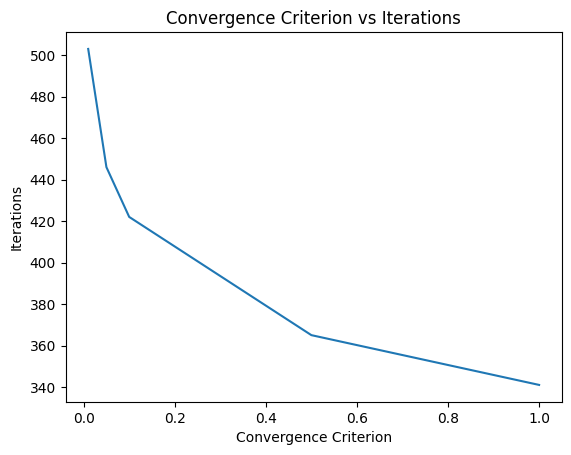

In [125]:
# a) The convergence criteria 
convergence_criterions = [0.01, 0.05, 0.1, 0.5, 1]
convergence_iterations = []

for convergence_criterion in convergence_criterions:
    results = run(bc, T_0, x, y, dx, dy, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, w))
    convergence_iterations.append(results["iterations"])

plt.plot(convergence_criterions, convergence_iterations)
plt.xlabel("Convergence Criterion")
plt.ylabel("Iterations")
plt.title("Convergence Criterion vs Iterations")
plt.show()

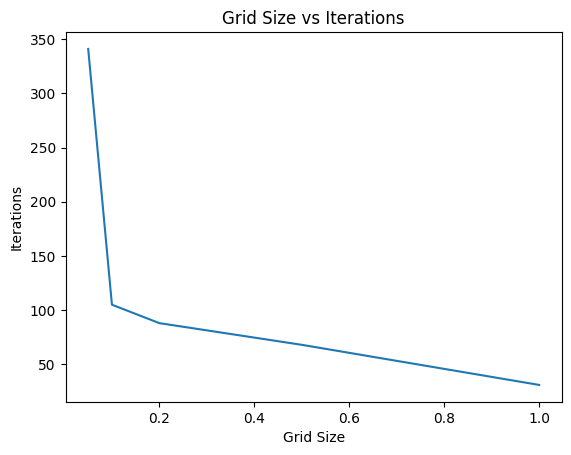

In [126]:
# b) The grid size while ensuring dx = dy
sizes = [0.05, 0.1, 0.2, 0.5, 1] # meters
convergence_iterations = []

for size in sizes:
    results = run(bc, T_0, x, y, size, size, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, w))
    convergence_iterations.append(results["iterations"])

plt.plot(sizes, convergence_iterations)
plt.xlabel("Grid Size")
plt.ylabel("Iterations")
plt.title("Grid Size vs Iterations")
plt.show()  

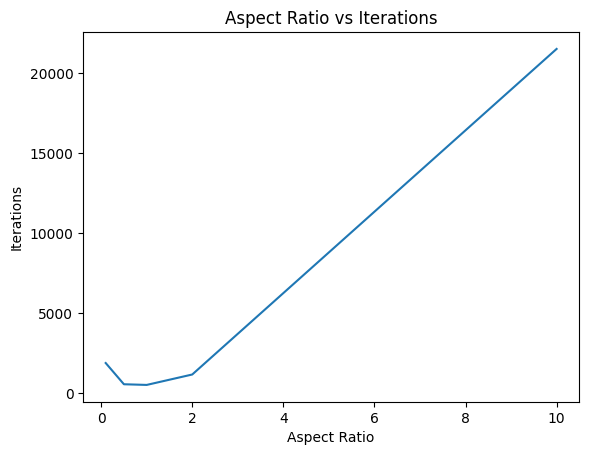

In [137]:
# c) The cell aspect ratio dx / dy
# aspect ratios are [0.1, 0.5, 1, 2, 10]
# dA = dx * dy
# AR = dx / dy => dy = dx / AR
# dA = dx^2 / AR => dx = sqrt(AR * dA)
aspect_ratios = [0.1, 0.5, 1, 2, 10]
dxs = [math.sqrt(ar * dx * dy) for ar in aspect_ratios]
dys = [dx / ar for ar in aspect_ratios]

convergence_iterations = []
convergence_criterion = 0.01

for i in range(len(aspect_ratios)):
    ldx = dxs[i]
    ldy = dys[i]
    results = run(bc, T_0, x, y, ldx, ldy, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, w))
    convergence_iterations.append(results["iterations"])

plt.plot(aspect_ratios, convergence_iterations)
plt.xlabel("Aspect Ratio")
plt.ylabel("Iterations")
plt.title("Aspect Ratio vs Iterations")
plt.show()

4. **Plot the contours of the converged temperature distribution obtained using one of the solution techniques. Contours can be plotted in MATLAB using the contourf function.**

Text(0, 0.5, 'y direction nodes')

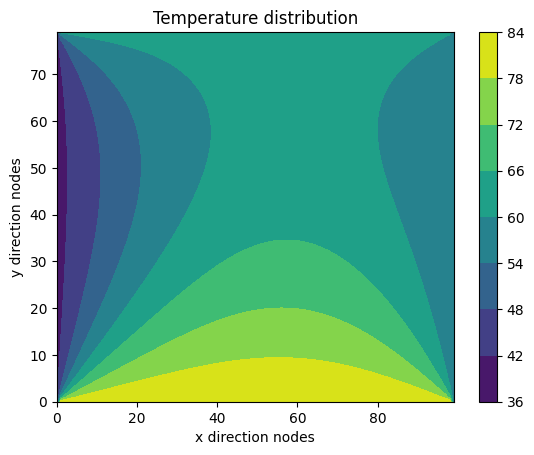

In [122]:

# PSOR
w = 1.9
results = run(bc, T_0, x, y, dx, dy, convergence_criterion, lambda T, dx, dy: psor(T, dx, dy, w))

plt.contourf(np.flipud(results["T"].T))
plt.colorbar()
# Set title and labels
plt.title("Temperature distribution")
plt.xlabel("x direction nodes")
plt.ylabel("y direction nodes")